In [ ]:
import os
import datetime
 
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')
HOME = '/content/drive/Shared drives/Практика МАДИ/Команды/Лузина_Маргарита/datasets/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_slice = 30

In [ ]:
# df_temp = pd.read_csv(HOME + 'keypoints_data_with_target_2_1.csv', delimiter=';', index_col='Unnamed: 0') 

import glob

all_files = glob.glob(HOME + "keypoints_data_with_target*.csv")
li = []

for filename in all_files:
    df = pd.read_csv(filename, delimiter=';', index_col='Unnamed: 0')
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)
df = frame
df.shape

# temp = df.loc[df['zahvat_predmeta']==1] - (df.loc[df['zahvat_predmeta']==1].index)

df['zahvat_Next'] = df['zahvat_predmeta'].shift(-1)
# replace NaN to allow float comparison
df.zahvat_Next.fillna(1, inplace = True)
# Apply your row-wise condition to create filter column
df.loc[(((df.zahvat_Next - df.zahvat_predmeta) < 0) | (df.zahvat_Next - df.zahvat_predmeta) > 0), 'Outlier'] = True
# filter
df_clean = df[df.Outlier != True]
# remove filter column
del df_clean['Outlier']
df1 = df.loc[df['zahvat_Next']==1.0]

df['zahvat_Next'] = df['zahvat_predmeta'].shift(-1)
df.iloc[144587,-1] = 0
df.loc[df.zahvat_Next - df.zahvat_predmeta == 1]

arrayindices = df1.loc[df1['zahvat_predmeta']==0].index

arrayindices = np.array(arrayindices.tolist())
new_list1 = [x + data_slice for x in arrayindices]
new_list2 = [x - data_slice for x in arrayindices]
new_list = sorted(new_list1+new_list2)
del new_list[-2:]

df['col1'] = df.index

xr = []
for x in range(len(new_list)): 
  if (x == 0) or (x % 2 == 0):
    list1 = df[df['col1'].between(new_list[x], new_list[x+1])]
    xr.append(list1)
pd.Series(xr).to_frame()
xr = np.asarray(xr)

df = pd.DataFrame.from_records(sum(map(list, xr), []))

df.drop(df.columns[[0,2,3,4,5,6,7,8,9,10,11,12,13,89,90,91]], axis=1, inplace=True)

df.to_csv('/content/slices' + str(data_slice) + '.csv', sep=';')

df_temp = (pd.read_csv('slices' + str(data_slice) + '.csv', delimiter=';', index_col='Unnamed: 0'))
df_full = df_temp.iloc[:,:]
df_full.rename(columns={'1': 'zahvat_predmeta'}, inplace=True)
df = df_temp.iloc[:,:]
df.rename(columns={'1': 'zahvat_predmeta'}, inplace=True)

column_indices = {name: i for i, name in enumerate(df.columns)}


n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

train_df['zahvat_predmeta'] = df_full['zahvat_predmeta'][0:train_df.shape[0]]
val_df['zahvat_predmeta'] = df_full['zahvat_predmeta'][train_df.shape[0]: train_df.shape[0] + val_df.shape[0]]
test_df['zahvat_predmeta'] = df_full['zahvat_predmeta'][train_df.shape[0] + val_df.shape[0] : train_df.shape[0] + val_df.shape[0] + test_df.shape[0]]

In [ ]:

df

,zahvat_predmeta,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88
0,0,621.584,777.544,0.449511,621.561,668.627,0.647341,586.203,603.843,0.383879,565.626,453.656,0.280190,765.862,432.994,0.279973,645.125,715.737,0.447779,765.739,765.633,0.211008,948.245,762.720,0.142017,845.249,527.355,0.382313,854.038,486.214,0.390579,1136.550,530.382,0.333561,1425.030,547.833,0.508286,836.466,571.449,0.290158,1045.33,680.432,0.130053,0.00,0.000,0.000000,0.000,0.000,0.000000,603.863,771.686,0.386994,0.0,0.0,0.0,594.940,745.125,0.732542,0.00,0.000,0.000000,0.00,0.000,0.000000,0.00,0.000,0.000000,1469.170,518.527,0.379045,1469.11,527.376,0.326312,1454.500,545.006,0.355153
1,0,621.539,777.524,0.366923,621.474,668.619,0.671062,583.257,598.028,0.416850,565.610,450.826,0.538675,765.790,430.254,0.415146,644.990,718.601,0.483546,753.980,762.816,0.279002,904.068,765.725,0.066530,845.213,521.467,0.305855,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,856.972,500.863,0.279250,1157.20,530.382,0.139234,1430.91,550.852,0.131605,0.000,0.000,0.000000,603.911,771.656,0.294871,0.0,0.0,0.0,592.071,745.162,0.697943,1469.24,530.191,0.098562,0.00,0.000,0.000000,1466.27,536.260,0.157792,0.000,0.000,0.000000,0.00,0.000,0.000000,0.000,0.000,0.000000
2,0,621.536,780.418,0.285704,618.621,668.655,0.656075,577.462,597.945,0.457254,565.599,450.812,0.482996,765.801,432.989,0.315774,645.105,715.802,0.407564,739.296,759.801,0.171002,0.000,0.000,0.000000,848.161,524.390,0.350740,854.037,492.023,0.245714,1133.620,530.323,0.221715,1425.060,547.914,0.484584,0.000,0.000,0.000000,0.00,0.000,0.000000,0.00,0.000,0.000000,0.000,0.000,0.000000,603.964,774.544,0.258821,0.0,0.0,0.0,592.118,748.157,0.653492,0.00,0.000,0.000000,0.00,0.000,0.000000,0.00,0.000,0.000000,1469.210,521.467,0.392592,1469.13,530.228,0.330773,1454.480,547.911,0.340757
3,0,621.403,783.392,0.436141,621.411,671.531,0.654769,580.352,600.976,0.464339,565.644,450.863,0.514396,765.828,430.231,0.348756,647.975,718.618,0.418100,762.745,765.649,0.161375,0.000,0.000,0.000000,839.393,524.379,0.341744,851.098,486.129,0.321298,1142.460,530.291,0.368990,1424.980,547.886,0.545840,836.400,574.391,0.235775,1054.20,683.304,0.133296,0.00,0.000,0.000000,0.000,0.000,0.000000,600.979,777.555,0.400101,0.0,0.0,0.0,586.244,745.205,0.726278,0.00,0.000,0.000000,0.00,0.000,0.000000,0.00,0.000,0.000000,1469.190,521.467,0.423627,1469.12,530.235,0.370955,1451.510,547.917,0.364563
4,0,618.498,780.497,0.453678,621.451,671.493,0.678636,577.455,603.839,0.481768,565.649,447.871,0.699234,759.815,433.019,0.524043,650.944,718.750,0.532871,783.398,765.675,0.329974,957.059,762.700,0.274086,839.332,530.341,0.331332,848.177,489.123,0.325590,1142.460,530.325,0.379598,1425.060,547.897,0.543324,836.414,580.339,0.281662,1139.54,692.077,0.165363,1419.17,700.960,0.248673,0.000,0.000,0.000000,598.075,777.489,0.422037,0.0,0.0,0.0,583.238,742.327,0.743365,1469.06,804.001,0.198757,1469.17,792.232,0.199149,0.00,0.000,0.000000,1469.210,521.449,0.392251,1469.15,530.240,0.348589,1457.400,544.967,0.387195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5119,1,506.773,768.760,0.746266,530.260,668.592,0.461178,524.316,662.729,0.304355,0.000,0.000,0.000000,0.000,0.000,0.000000,533.179,671.641,0.659010,736.294,668.710,0.742246,874.652,733.298,0.698603,792.250,559.731,0.479724,786.435,618.539,0.509324,880.516,739.220,0.290268,939.412,833.490,0.068060,792.274,521.439,0.390713,1095.32,592.046,0.550186,1392.62,559.703,0.466090,0.000,0.000,0.000000,480.351,768.774,0.763435,0.0,0.0,0.0,456.631,730.446,0.829078,1451.59,656.857,0.286286,0.00

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):

    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
 

    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}
 
    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift
 
    self.total_window_size = input_width + shift
 
    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]
 
    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
 
  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
# w2 = WindowGenerator(input_width=15, label_width=15, shift=1,
#                      label_columns=['zahvat_predmeta'])


def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

# Stack three slices, the length of the total window:
# example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
#                            np.array(train_df[20:20+w2.total_window_size]),
#                            np.array(train_df[40:40+w2.total_window_size])])


# example_inputs, example_labels = w2.split_window(example_window)

# print('All shapes are: (batch, time, features)')
# print(f'Window shape: {example_window.shape}')
# print(f'Inputs shape: {example_inputs.shape}')
# print(f'labels shape: {example_labels.shape}')

In [ ]:

# w2.example = example_inputs, example_labels

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

# Each element is an (inputs, label) pair
# w2.train.element_spec

# for example_inputs, example_labels in w2.train.take(1):
#   print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
#   print(f'Labels shape (batch, time, features): {example_labels.shape}')

In [ ]:
MAX_EPOCHS = 5

def compile_and_fit(model, window, patience=25):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val)
  return history

OUT_STEPS = 60

# for el in df_list:
multi_window = WindowGenerator(input_width=OUT_STEPS,
                              label_width=OUT_STEPS,
                              shift=OUT_STEPS, label_columns=['zahvat_predmeta'])

In [ ]:
CONV_WIDTH = 5

multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

Epoch 1/5
109/109 [==============================] - 3s 21ms/step - loss: 0.2172 - mean_absolute_error: 0.4238 - val_loss: 0.2195 - val_mean_absolute_error: 0.3968
Epoch 2/5
109/109 [==============================] - 2s 20ms/step - loss: 0.1428 - mean_absolute_error: 0.3040 - val_loss: 0.2402 - val_mean_absolute_error: 0.4011
Epoch 3/5
109/109 [==============================] - 2s 20ms/step - loss: 0.1250 - mean_absolute_error: 0.2803 - val_loss: 0.2416 - val_mean_absolute_error: 0.4003
Epoch 4/5
109/109 [==============================] - 2s 20ms/step - loss: 0.1145 - mean_absolute_error: 0.2651 - val_loss: 0.2410 - val_mean_absolute_error: 0.3980
Epoch 5/5
109/109 [==============================] - 2s 20ms/step - loss: 0.1040 - mean_absolute_error: 0.2504 - val_loss: 0.2396 - val_mean_absolute_error: 0.3983


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 5, 76)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 256)            97536     
_________________________________________________________________
dense_2 (Dense)              (None, 1, 4560)           1171920   
_________________________________________________________________
reshape_2 (Reshape)          (None, 60, 76)            0         
Total params: 1,269,456
Trainable params: 1,269,456
Non-trainable params: 0
_________________________________________________________________
29/29 [==============================] - 0s 4ms/step - loss: 1.5798 - mean_absolute_error: 0.8419


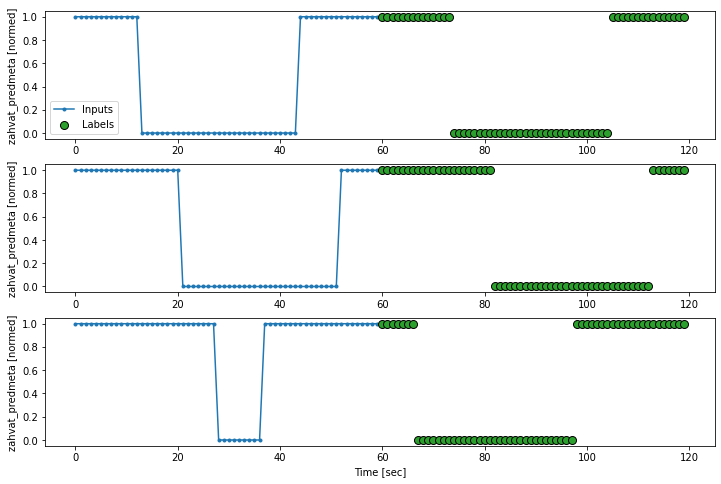

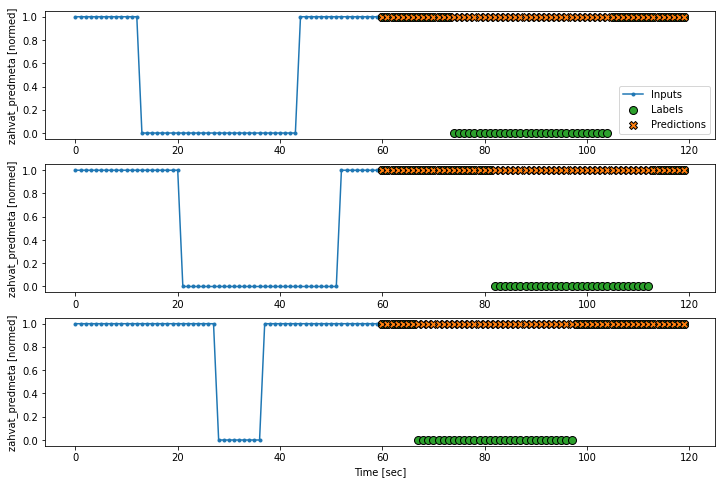

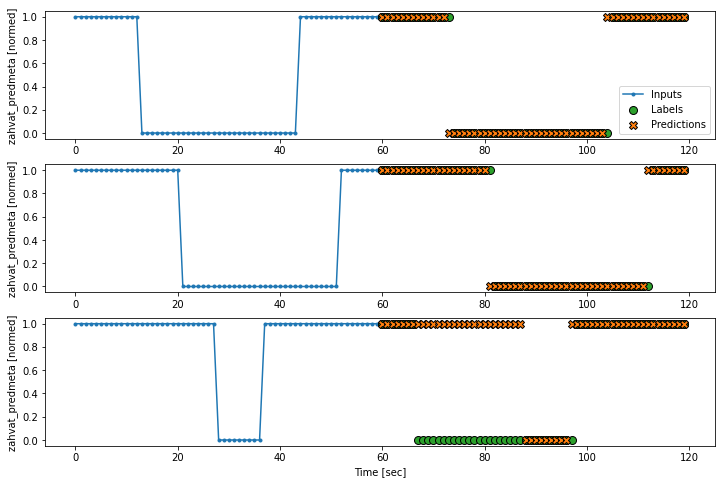

In [ ]:
multi_conv_model.summary()

def plot(self, model=None, plot_col='zahvat_predmeta', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [sec]')

WindowGenerator.plot = plot

OUT_STEPS = 60
multi_window = WindowGenerator(input_width=OUT_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)


class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)


